# Updated Plots for Streamlit Using Multiple Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [2]:
# Sample Data
# df_sample = pd.read_csv("../../../data/Preprocessed_datasets/sample_data_before_preprocessing.csv")
df_sample = pd.read_csv("../../../data/Preprocessed_datasets/sample_data_formatted.csv")

# Medical Practice Data
df_med = pd.read_csv("../../../data/Preprocessed_datasets/Kaggle_medical_practice_20.csv", index_col=0)

# Third Data
df_ins = pd.read_csv("../../../data/Preprocessed_datasets/Insurance_claims_mendeleydata_6.csv")

<hr style= "border: 3px solid blue">

In [3]:
def preprocess_sample_dataset(df):
    """
    These are the preprocessing steps for sample_data_formatted.csv to be 
    transformed to the format that is used for Statewise Comparison 
    of Car Accident Claims

    Args
    ---------------------
    df_samp: pd.DataFrame | sample dataset to be transformed

    Returns
    ---------------------
    df_samp: pd.DataFrame | dataframe after simple preprocessing

    Errors Raised
    --------------------
    KeyError | If a dataframe is used without the same column names, a KeyError will be raised

    """
    # Get the claim amount as it is final target variable
    df['claim_amount'] = np.where(df['total_bills']<=df['total_coverage'],df['total_bills'],df['total_coverage'])
    # total_bills
    df['total_bills'] = np.where(df['total_bills'].isnull(),df['claim_amount'],df['total_bills'])
    # drop null value rows from claim amount
    df = df.dropna(subset=['claim_amount'])
    # drop rows with claim amount '0'
    df = df[~(df['claim_amount']==0)]
    # drop rows with -ve age
    df = df[~(df['age']<0)]
    
    # String Format for State Abbreviations
    df["state"] = df["state"].str.upper()

    # Selecting States with Fewer Than 45 rows of observations
    small_obs = df["state"].value_counts()[df["state"].value_counts() < 45].index

    # Binning small-observation states
    df.loc[df["state"].isin(small_obs), "state"] = "Other"

    ### Script for Binning Type of Injury Column

    df.rename(columns={"injury_type":"Type of Injury"}, inplace=True)

    df = df.dropna(subset="Type of Injury")
    # First consolidation - the backslash is not separated from 'Other Injury' with a space
    df.loc[df["Type of Injury"] == "Other Injury/ Pain", "Type of Injury"] = "Other Injury / Pain"

    # General Traumatic Brain Injury consolidation
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic Brain Injury.", "Type of Injury"] \
    = "Other Injury / Pain; Traumatic Brain Injury"

    # Removing LOC ("Loss of Consciousness") from the category's granularity
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic Brain Injury - w/LOC", "Type of Injury"] \
    = "Other Injury / Pain; Traumatic Brain Injury"

    # Handling Excessive spaces between words
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic  Brain  Injury", "Type of Injury"] \
    = "Other Injury / Pain; Traumatic Brain Injury"

    # Another Different Entry with Redundant Information
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic Brain Injury - w/LOC; Traumatic  Brain  Injury", "Type of Injury"]\
    = "Other Injury / Pain; Traumatic Brain Injury"

    # Same
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic Brain Injury - w/LOC; Traumatic Brain Injury.", "Type of Injury"]\
    = "Other Injury / Pain; Traumatic Brain Injury"

    # Same
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic  Brain  Injury; Traumatic  Brain  Injury", "Type of Injury"] \
    = "Other Injury / Pain; Traumatic Brain Injury"


    # ---- Handling Fatal Cases ----

    # 124 Distinct Injuries resulting in Death

    # Consolidate entries containing "Death" and "Traumatic Brain Injury"                                   #### CHECK
    df.loc[df["Type of Injury"].str.contains("(?=.*Death)(?=.*Traumatic Brain Injury)"), "Type of Injury"] = "Death"

    # -------- Broken Bones -------
    df.loc[df["Type of Injury"].str.contains("Traumatic Brain Injury.*Broken Bones"), "Type of Injury"]\
    = "Other Injury / Pain; Traumatic Brain Injury; Broken Bones"

    df.loc[df["Type of Injury"].str.contains("Other Injury.*Broken Bones"), "Type of Injury"]\
    = "Other Injury / Pain; Traumatic Brain Injury; Broken Bones"

    # ------- Ruptured Discs -> regular expressions for the "Other Pain" and "Traumatic Brain Injury" as superseding categories
    df.loc[df["Type of Injury"].str.contains("(?=Other Injury / Pain)(?=.*Herniated/Bulging/Ruptured Disc)(?=.*Traumatic Brain Injury)"),\
    "Type of Injury"] = "Other Injury / Pain; Traumatic Brain Injury; Herniated/Bulging/Ruptured Disc"

    # ------ Ruptured Discs -> regular expressions for the "Other Pain" and "Traumatic Brain Injury" as superseding categories
    df.loc[df["Type of Injury"].str.contains("(?=Other Injury / Pain)(?=.*Herniated/Bulging/Ruptured Disc)"),\
    "Type of Injury"] = "Other Injury / Pain; Herniated/Bulging/Ruptured Disc"

    # Capturing the last remaining values
    df.loc[df["Type of Injury"].str.contains("Herniated/Bulging/Ruptured Disc"), "Type of Injury"]\
    = "Other Injury / Pain; Herniated/Bulging/Ruptured Disc"

    ##### AT THIS POINT: Remaining un-consolidated values all represent less than 1% of total values #########

    # -------- Tendon/Ligament -> Consolidating into the larger bin
    df.loc[df["Type of Injury"] == "Tendon/Ligament Tear/Rupture", "Type of Injury"] = "Other Injury / Pain; Tendon/Ligament Tear/Rupture"

    # ------------PTSD etc using the larger bin in existence
    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic Brain Injury - w/LOC; Anxiety,PTSD,Depression,Stress", "Type of Injury"]\
    = "Other Injury / Pain; Traumatic  Brain  Injury; Anxiety,PTSD,Depression,Stress"

    df.loc[df["Type of Injury"] == "Other Injury / Pain; Traumatic Brain Injury.; Anxiety,PTSD,Depression,Stress", "Type of Injury"]\
    = "Other Injury / Pain; Traumatic  Brain  Injury; Anxiety,PTSD,Depression,Stress"

    # After these bins have been created, the top 20 Values account for 96.2% of all rows in the data.

    # Binning all values not found in the top 20
    exclusion_list = df["Type of Injury"].value_counts(normalize =True)[:20].index

    # '~' accesses the complement - "Not In" the exclusion list
    df.loc[~df["Type of Injury"].isin(exclusion_list), "Type of Injury"] = "Other Injury"

    # TBI
    df.loc[df["Type of Injury"].str.contains("Traumatic Brain Injury"), "Type of Injury"] = "Traumatic Brain Injury"

    # Broken Bones
    df.loc[df["Type of Injury"].str.contains("Broken Bones"), "Type of Injury"] = "Broken Bones"

    # 21 Bins of Values left, and the final bin contains roughly 3.8 % of all entries
    df["Type of Injury"] = df["Type of Injury"].str.replace("Other Injury / ", "")

    df["Type of Injury"] = df["Type of Injury"].str.replace("Pain; ", "")

    # Bins for Age Plots
    bins = [-np.inf, 2, 12, 18, 35, 60, np.inf]
    labels = ["Infant 0-2", "Child 2-12", "Teenager 12-18", "Young Adult 18-35",
          "Adult 35-60", "Senior Citizen 60+"]
    
    df["age_bracket"] = pd.cut(df["age"], bins=bins, labels=labels)

    # Filling Nulls Logically
    df["airbag_deployed"] = df["airbag_deployed"].fillna("Unknown")

    df["accident_type"] = df["accident_type"].str.replace("It involved multiple cars", "Multi Car")
    df["accident_type"] = df["accident_type"].fillna("Unknown")
    
    return df

In [4]:
# Processing for insurance data
def preprocess_insurance_data(data):
    """
    Preprocessing steps for Insurance_claims_mendeleydata_6.csv
    to be transformed in a manner that allows for state-wise visualization

    Args
    ---------------
    data: pd.DataFrame | pandas dataframe to be used for state-wise plots

    Returns
    ---------------
    data : pd.DataFrame | preprocessed with minimal steps 

    Errors Raised
    ---------------
    KeyError | if data with different column names is used, then this function will raise an error

    """

    data = data.rename(columns={"total_claim_amount":"claim_amount",
                                "insured_sex":"gender"})
    data["gender"] = data["gender"].str.title()

    # Bins for Age Plots
    bins = [-np.inf, 2, 12, 18, 35, 60, np.inf]
    labels = ["Infant 0-2", "Child 2-12", "Teenager 12-18", "Young Adult 18-35",
          "Adult 35-60", "Senior Citizen 60+"]
  
    data["age_bracket"] = pd.cut(data["age"], bins=bins, labels=labels)

    return data

In [5]:
df = preprocess_sample_dataset(df_sample)
df_insurance = preprocess_insurance_data(df_ins)

## State Data
Insurance_claims_medeleydata_6 has state-related data, but it only comprises 700+ rows of observations. I will try to consolidate them into a single entity. 

### Known Preprocessing Requirements:

- Sample Data

- Insurance Claim Data (Small Dataset)

### Sample Dataset

In [5]:
df = preprocess_sample_dataset(df_sample)

In [6]:
df.shape

(23385, 30)

### Insurance Claim Data (Small)

In [7]:
def preprocess_insurance_data(data):
    """
    Preprocessing steps for Insurance_claims_mendeleydata_6.csv
    to be transformed in a manner that allows for state-wise visualization

    Args
    ---------------
    data: pd.DataFrame | pandas dataframe to be used for state-wise plots

    Returns
    ---------------
    data : pd.DataFrame | preprocessed with minimal steps 

    Errors Raised
    ---------------
    KeyError | if data with different column names is used, then this function will raise an error

    """

    data = data.rename(columns={"total_claim_amount":"claim_amount",
                                "insured_sex":"gender"})
    data["gender"] = data["gender"].str.title()

    return data

In [8]:
# Calling the function
df_insurance = preprocess_insurance_data(df_ins)

In [9]:
df_insurance.shape

(753, 27)

In [10]:
df_insurance["state"].value_counts()

state
NY    204
WV    178
SC    175
VA     85
NC     76
PA     22
OH     13
Name: count, dtype: int64

# Sample Data Visualization Function

In [11]:
# For Sample Dataset
def plot_states(data):

    # Style
    sns.set()

    # Figure Creation
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plotting Named States Only (meaning 45+ rows of data) by Median from highest median to lowest, change as needed
    if "OTHER" in data["state"].unique():
        grouped = data.groupby("state")["claim_amount"].agg(["median", "mean"]).drop("OTHER").sort_values(by="median", ascending=False)
    else:
        grouped = data.groupby("state")["claim_amount"].agg(["median", "mean"]).sort_values(by="median", ascending=False)
    grouped.plot(kind="bar", rot=0, ax=ax, color=sns.set_palette("coolwarm", n_colors=2))
    # Labels and Format
    ax.legend(["Median", "Mean"])
    ax.set_ylabel("Claim Amount in USD")
    ax.set_xlabel("States")
    ax.set_title("Mean and Median Claims by State Sorted by Median Claim", fontsize=16, loc="left")     
    # Ticks
    # ax.set_yticks(np.linspace(0, 100_000, 6), labels=["0", "$20k", "$40k","$60k","$80k","$100k"])
   
    # Annotation -> commented out to make function more generally usable
    # ax.annotate(xy=(2.25,87500), xytext=(3.2, 62000), text="Florida has several very large claims \ninflating the state mean",
    #            arrowprops={"arrowstyle":"->", "linewidth":2, "color":"black"});

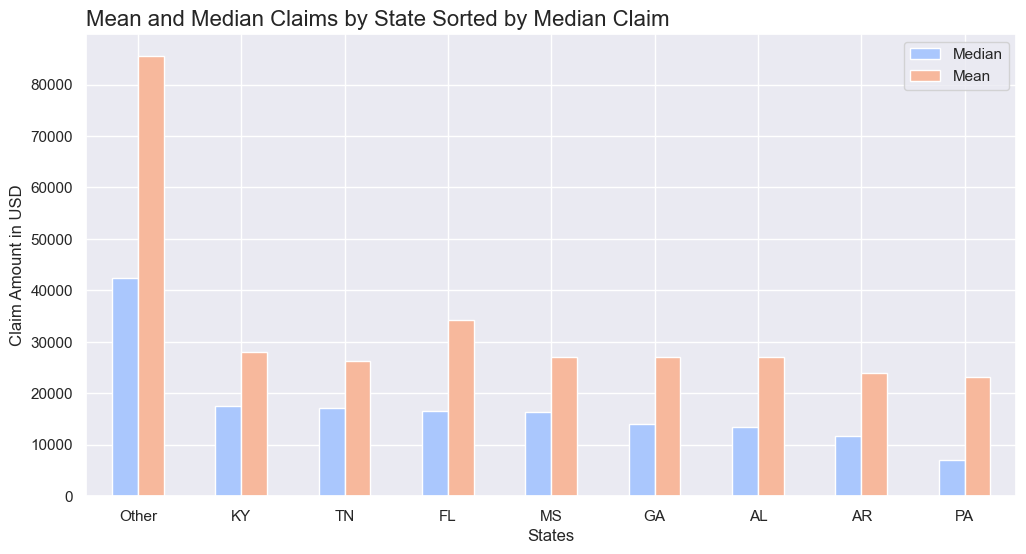

In [12]:
# Function Call
plot_states(df)

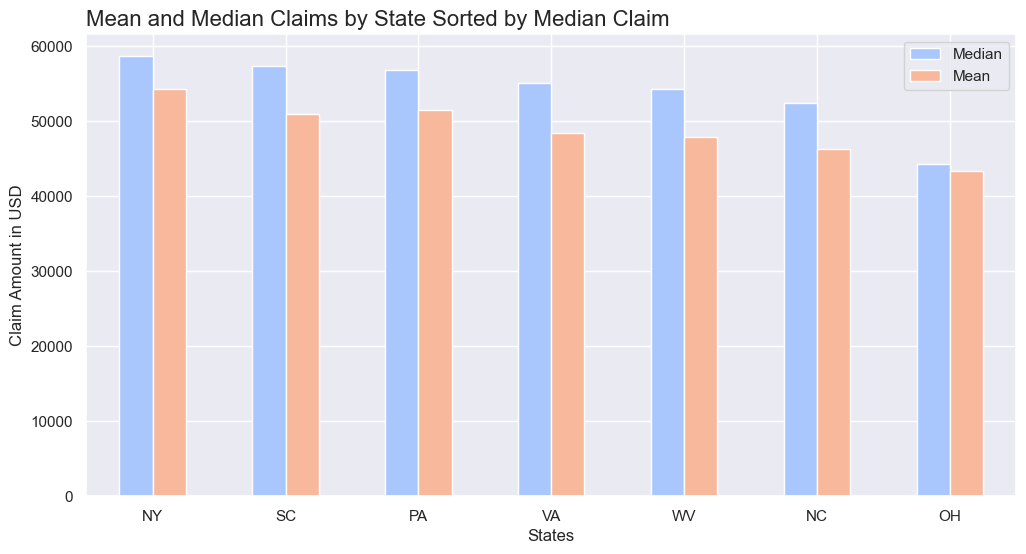

In [13]:
plot_states(df_insurance)

# Streamlit Version 

### Plotly Definition

In [14]:
def plotly_states(data):

    """
    Function to generate a plotly figure of barplots of mean and median state claim values for car accidents
    compatible with sample_data_formatted.csv and Insurance_claims_mendeleydata_6.csv

    Args
    -----------
    data: pd.DataFrame | data with columns: ["state", "total_claim_amount"]

    Returns
    -----------
    plotly figure | barplot with hover values of State, Mean/Median Value 

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """

    # Grouping data by state and calculating median and mean
    if "Other" in data["state"].unique():
        grouped = data.groupby("state")["claim_amount"].agg(["median", "mean"]).drop("Other").sort_values(by="median", ascending=False)
    else:
        grouped = data.groupby("state")["claim_amount"].agg(["median", "mean"]).sort_values(by="median", ascending=False)

    # Resetting index to make 'state' a column for Plotly
    grouped = grouped.reset_index()

    # Creating Plotly figure
    fig = px.bar(grouped, x='state', y=['median', 'mean'],
                 labels={'value': 'Claim Amount in USD', 'state': 'States'},
                 title='Mean and Median Claims by State Sorted by Median Claim',
                 barmode='group', 
                 template="plotly")
    
    # Legend
    fig.update_layout(legend_title='')

    # Customizing hover info
    fig.update_traces(hovertemplate='State: %{x}<br>Value: %{y:.2f}')

    fig.for_each_trace(lambda t: t.update(name=t.name.capitalize()))

    # Returning the Plotly figure
    return fig

In [15]:
plotly_states(df_insurance)

<hr style="border: 3px solid blue">

# Boxplots 

### Seaborn

In [18]:
def box_states(data):
    #Style
    sns.set()

    # Distribution of Claims by State -> very unreliable imo
    fig, ax = plt.subplots(figsize=(16,6))

    # Creating a list of states ordered by their median percentile value to provide a left-to-right visual structure 
    upper_q = list(data.groupby("state")["claim_amount"].median().sort_values(ascending=False).index)
    upper_q = [i for i in upper_q if i != "Other"]

    # Boxplot for Claim Distribution
    sns.boxplot(data=data.reset_index(drop=True).sort_values(by="claim_amount", ascending=False), x="state", y="claim_amount", hue="state", 
                showfliers=False, palette="coolwarm", legend=False, order=upper_q, ax=ax)

    # Labels and Titles
    ax.set_ylabel("Total Claim in USD")
    ax.set_xlabel("States")
    ax.set_title("Distribution of Car Accident Claims in Different States", loc="left", fontsize=16);

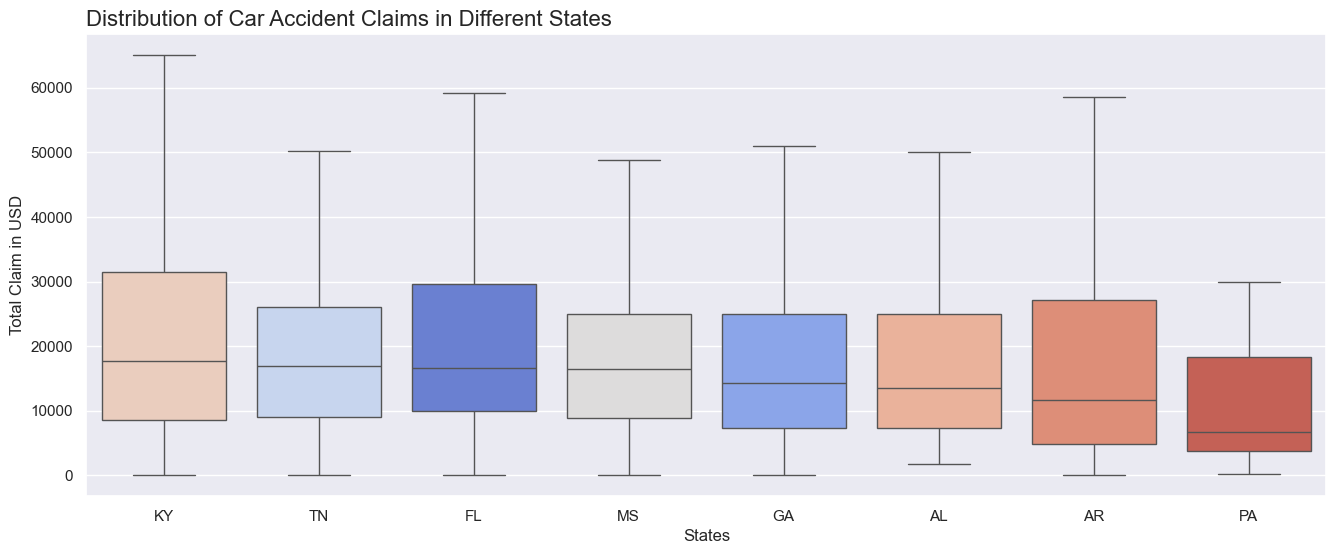

In [19]:
box_states(df)

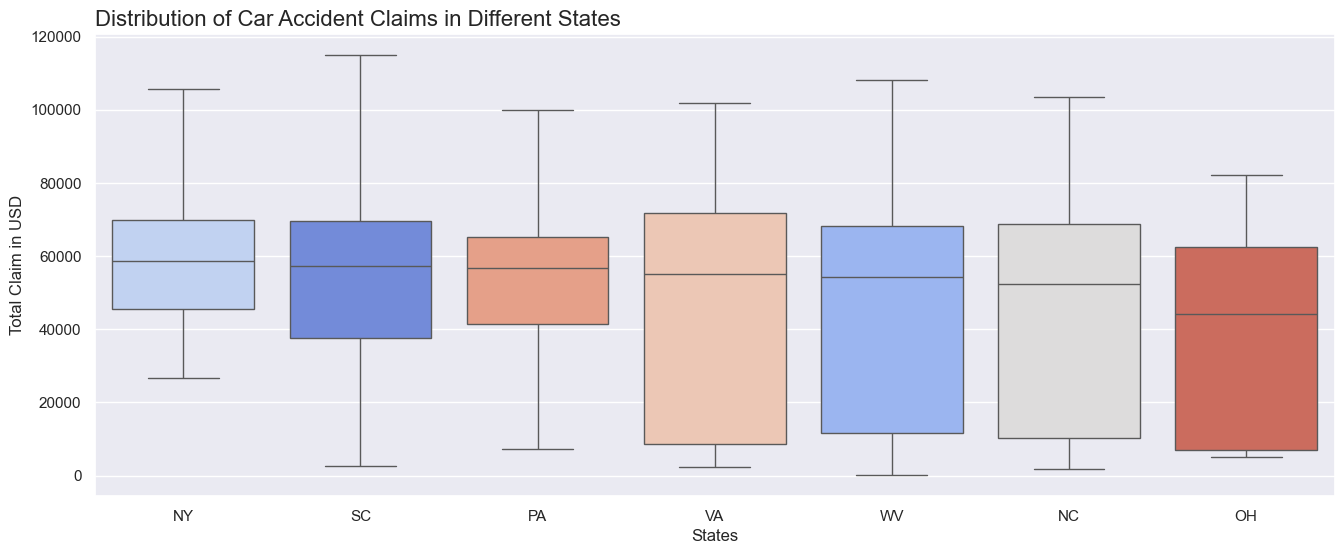

In [20]:
box_states(df_insurance)

### Plotly

In [13]:
def plotly_box_states(data):
    """
    Function to generate a plotly figure of boxplots of car accidents claim distributions by state
    compatible with sample_data_formatted.csv and Insurance_claims_mendeleydata_6.csv

    Args
    -----------
    data: pd.DataFrame | data with columns: ["state", "total_claim_amount"]

    Returns
    -----------
    plotly figure | boxplot with hover values of State, [min, lower fence, 25 percentile, median, 75 percentile, upper fence, max] 

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """
    
    # Filter Data for States == Other
    data = data[data["state"] != "Other"]

    # Creating a list of states ordered by their median percentile value 
    # to provide a left-to-right visual structure 
    upper_q = list(data.groupby("state")["claim_amount"].median().sort_values(ascending=False).index)
    
    # Create traces for each state -> this was the only way I could get the whisker/plot scale correct
    traces = []
    for state in upper_q:
        state_data = data[data['state'] == state]
        trace = go.Box(
            y=state_data['claim_amount'],
            name=state,
            boxpoints='all',  # Show all points to maintain correct whisker length
            jitter=0.3,
            pointpos=-1.8,
            marker=dict(opacity=0),  # Make point markers invisible
            line=dict(width=2),
            boxmean=False  # Do not show mean
        )
        traces.append(trace)

    # Create the figure
    fig = go.Figure(data=traces)

    # Update layout
    fig.update_layout(
        title="Distribution of Car Accident Claims in Different States",
        yaxis=dict(
            title="Total Claim in USD"
        ),
        xaxis=dict(
            title="State"
        ),
        showlegend=False,
        template="plotly"
    )
    
    # Calculate IQR for each state to determine y-axis range
    iqr_ranges = data.groupby('state')['claim_amount'].apply(lambda x: (x.quantile(0.25), x.quantile(0.75)))
    iqr_min, iqr_max = iqr_ranges.apply(lambda x: x[0]).min(), iqr_ranges.apply(lambda x: x[1]).max()
    iqr = iqr_max - iqr_min

    # Update y-axis range to be slightly larger than the IQR range
    fig.update_yaxes(range=[-1000, iqr_max + 1.5 * iqr])

    return fig

In [14]:
plotly_box_states(df)

In [15]:
plotly_box_states(df_insurance)

<hr style="border: 2px solid blue">

# Gender

These plots will only work for the Kaggle_medical_practice_20.csv and Insurance_claims_mendeleydata_6.csv

In [24]:
df_med.head()

total_claim_amount  severity  age  private_attorney  marital_status  \
0               57041         7   62                 1               2   
1              324976         6   38                 1               2   
2              135383         4   34                 1               2   
3              829742         7   42                 1               1   
4              197675         3   60                 0               2   

         specialty          insurance  gender  
0  Family Practice            Private    Male  
1            OBGYN       No Insurance  Female  
2       Cardiology            Unknown    Male  
3       Pediatrics       No Insurance  Female  
4            OBGYN  Medicare/Medicaid  Female

In [25]:
def plot_gender(data):
    sns.set()

    if "claim_amount" in data.columns:
        data = data.rename(columns={"claim_amount":"total_claim_amount"})

    # Create a GridSpec with 2 rows and 2 columns
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

    # First row, first column
    ax1 = fig.add_subplot(gs[0, 0])
    sns.kdeplot(data=data.query("gender == 'Male'"), x="total_claim_amount", fill=True, ax=ax1, color="blue")
    ax1.get_yaxis().set_visible(False)
    ax1.axvline(data.query("gender == 'Male'")["total_claim_amount"].median(), 
                label=f"Male Median: \n${data.loc[data['gender'] == 'Male', 'total_claim_amount'].median():,.2f}", 
                linestyle="--", color="darkblue")
    ax1.legend()
    ax1.set_xlabel("Total Claim in USD")
    ax1.set_title('Male Claim Amounts')

    # First row, second column
    ax2 = fig.add_subplot(gs[0, 1])
    sns.kdeplot(data=data.query("gender == 'Female'"), x="total_claim_amount", ax=ax2, fill=True, color="lightcoral")
    ax2.get_yaxis().set_visible(False)
    ax2.axvline(data.query("gender == 'Female'")["total_claim_amount"].median(), 
                label=f"Female Median: \n${data.loc[data['gender'] == 'Female', 'total_claim_amount'].median():,.2f}",
                  linestyle="--", color="darkred")
    ax2.legend()
    ax2.set_xlabel("Total Claim in USD")
    ax2.set_title('Female Claim Amounts')

    # Second row (spans both columns)
    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(data=data, x="total_claim_amount", hue="gender", fill=True, alpha= .3, ax=ax3, palette=["blue", "lightcoral"])
    ax3.get_yaxis().set_visible(False)
    ax3.set_xlabel("Total Claim in USD")
    
    ax3.legend(["Female", "Male"])
    ax3.set_title('Male vs Women Overlaid')

    # Super-Title
    fig.suptitle(f"Distribution of All Claim Amounts for Men vs Women", fontsize=16, x=.2, y=.975)

    # Adjust the layout to prevent overlapping titles and labels
    plt.tight_layout()
    plt.show()

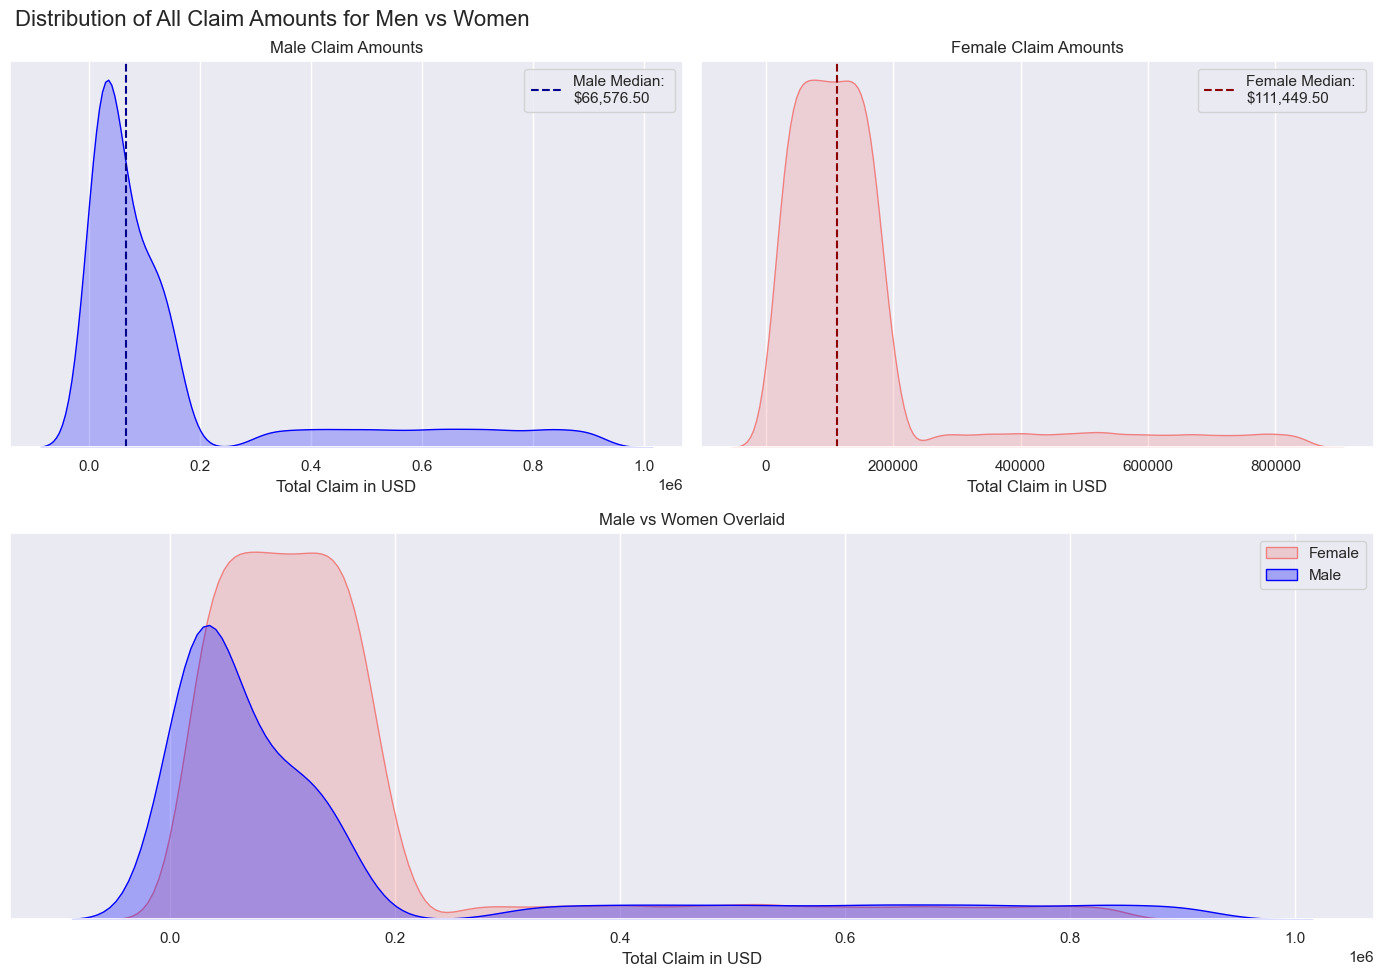

In [26]:
# Testing Seaborn Function
plot_gender(df_med)

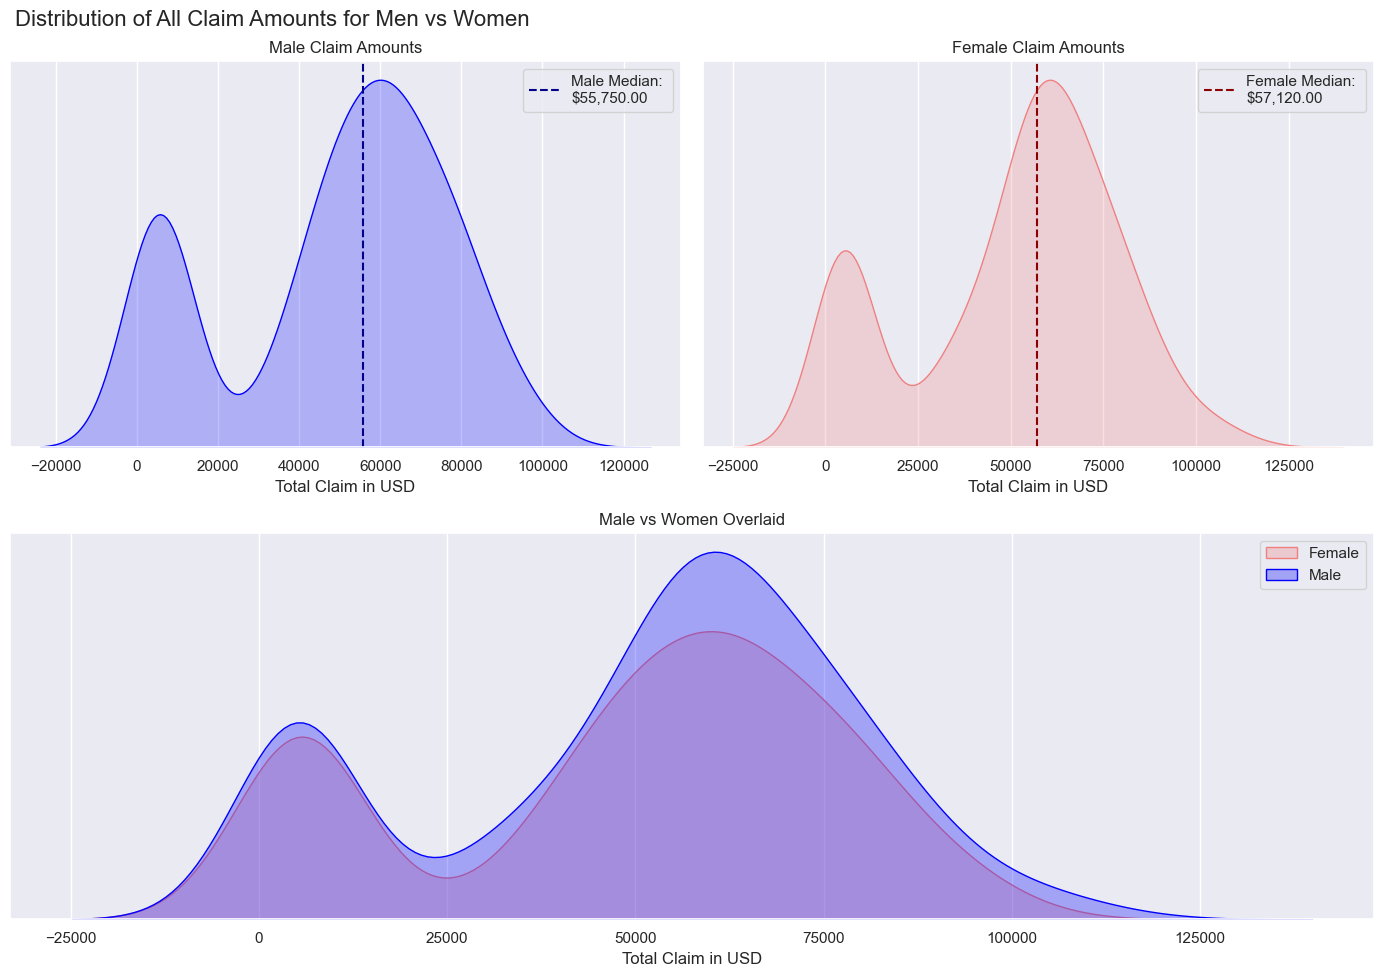

In [27]:
plot_gender(df_insurance)

### Plotly KDE of Gender

In [21]:
def plotly_gender(data):
    """
    Function to generate a plotly figure of KDE distributions for Genders 
    compatible with Kaggle_medical_practice_20.csv and Insurance_claims_mendeleydata_6.csv

    Args
    -----------
    data: pd.DataFrame | data with columns: ["gender", "total_claim_amount"]

    Returns
    -----------
    plotly figure | 3 kde plots with hover values of x coordinates (claim value)

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """
    
    if "claim_amount" in data.columns:
        data = data.rename(columns={"claim_amount":"total_claim_amount"})

    male_data = data.query("gender == 'Male'")['total_claim_amount']
    female_data = data.query("gender == 'Female'")['total_claim_amount']

    male_median_x = male_data.median()
    female_median_x = female_data.median()

    # KDEs
    male_kde = ff.create_distplot([male_data], group_labels=['Male'], show_hist=False, show_rug=False)
    female_kde = ff.create_distplot([female_data], group_labels=['Female'], show_hist=False, show_rug=False)

    # Create subplots
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=(f'Male Claim Amounts - Median Claim ${male_median_x:,.2f}', f'Female Claim Amounts - Median Claim ${female_median_x:,.2f}', 'Male vs Women Overlaid'),
                        specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"colspan": 2}, None]],
                        row_heights=[0.5, 0.5],
                        column_widths=[0.5, 0.5])

    # Male KDE Plot
    for trace in male_kde['data']:
        trace["hoverinfo"] = 'x'
        trace["showlegend"] = False
        fig.add_trace(trace, row=1, col=1)

    male_median_y = male_kde['data'][0]['y'].max()
    
    # Adding a vline
    fig.add_shape(type="line",
                  x0=male_median_x, y0=0,
                  x1=male_median_x, y1=male_median_y,
                  line={"color":"darkblue","dash":"dash"},
                  row=1, col=1)

    # Female KDE Plot
    for trace in female_kde['data']:
        trace["hoverinfo"] = 'x'
        trace["showlegend"] = False
        fig.add_trace(trace, row=1, col=2)

    female_median_y = female_kde['data'][0]['y'].max()
    
    # Adding a vline
    fig.add_shape(type="line", 
              x0=female_median_x, y0=0, 
              x1=female_median_x, y1=female_median_y, 
              line=dict(color="darkred", dash="dash"),
              row=1, col=2)

    # Overlaid KDE Plot
    fig.add_trace(go.Scatter(x=male_kde['data'][0]['x'], y=male_kde['data'][0]['y'], 
                             mode='lines', name='Male', fill='tozeroy', line=dict(color='blue'), opacity=0.3,
                             hoverinfo='x'), 
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=female_kde['data'][0]['x'], y=female_kde['data'][0]['y'], 
                             mode='lines', name='Female', fill='tozeroy', line=dict(color='lightcoral'), opacity=0.3,
                             hoverinfo='x'), 
                  row=2, col=1)

    # Update layout
    fig.update_layout(height=800, width=1200, title_text="Distribution of All Claim Amounts for Men vs Women")
    fig.update_xaxes(title_text="Total Claim in USD", row=1, col=1)
    fig.update_xaxes(title_text="Total Claim in USD", row=1, col=2)
    fig.update_xaxes(title_text="Total Claim in USD", row=2, col=1)

    fig.update_layout(showlegend=True, legend=dict(x=0.875, y=0.275))
    fig.update_yaxes(showticklabels=False)

    # Show plot
    fig.show()

In [22]:
plotly_gender(df_med)

In [18]:
plotly_gender(df_insurance)

# Box Plot Gender

In [19]:
def plotly_box_gender(data):
    """
    Function to generate a plotly figure of Boxplot distributions without outliers for Genders Across Insurance Types
    compatible with Kaggle_medical_practice_20.csv

    Args
    -----------
    data: pd.DataFrame | data with columns: ["state", "total_claim_amount", "insurance"]

    Returns
    -----------
    plotly figure | boxplot with hover values of State, then any of: 
    [max, upper fence, 75th percentile, median, 25th percentile, lower fence, min]

    Errors
    -----------
    KeyError if data do not contain the correct columns
    """
    
    # data = data[data["total_claim_amount"] < data["total_claim_amount"].quantile(.95)]

    # Creating a list of states ordered by their median percentile value 
    # to provide a left-to-right visual structure 
    fig = px.box(df_med, x="insurance", y="total_claim_amount", color="gender")

    # Update layout
    fig.update_layout(
        title="Distribution of Claims by Insurance Type for Men and Women",
        yaxis=dict(
            title="Total Claim in USD"
        ),
        xaxis=dict(
            title="Insurance Type"
        ),
        showlegend=True,
        template="plotly"
    )
    
    fig.update_layout(legend_title='Gender')
    
    return fig

In [20]:
plotly_box_gender(df_med)

<hr style = "border: 3px solid blue">

# Other plotting material

In [ ]:
# Creating a 2-column df of claim and state

states = pd.concat([df_sample[["state", "claim_amount"]], 
           df_ins[["state", "total_claim_amount"]].rename(columns={"total_claim_amount":"claim_amount"})])

In [ ]:
# Verifying that no new nulls were added to the data
states["state"].isna().sum(), df_sample["state"].isna().sum()

In [ ]:
# Pre-binning - too many low observation items
states["state"].value_counts()

### Binning States to Avoid States with < 45 Observations

In [ ]:
states["state"].value_counts()[states["state"].value_counts() <45].index

# Optionally Binning State Data

# Selecting States with Fewer Than 45 rows of observations
small_obs = states["state"].value_counts()[states["state"].value_counts() <45].index

# Binning small-observation states
states.loc[states["state"].isin(small_obs), "state"] = "Other"

states["state"].value_counts(dropna=False)

In [ ]:
# Figure Creation
fig, ax = plt.subplots(figsize=(12,8))

# Plotting Named States Only (meaning 45+ rows of data) by Median from highest median to lowest, change as needed
states.groupby("state")["claim_amount"].agg(["median", "mean"]).drop("Other").sort_values(by="median", ascending=False)\
.plot(kind="bar", rot=0, ax=ax, color=sns.set_palette("coolwarm", n_colors=2))
# Labels and Format
ax.legend(["Median", "Mean"])
ax.set_ylabel("Claim Amount in USD")
ax.set_xlabel("States")
# fig.suptitle("Mean and Median Claims by State", y=.95, x=0.125, ha="left", fontsize=16)
ax.set_title("Mean and Median Claims by State Sorted by Median Claim", fontsize=16, loc="left") 

# Ticks
ax.set_yticks(np.linspace(0, 100_000, 6), labels=["0", "$20k", "$40k","$60k","$80k","$100k"])
# Annotation
ax.annotate(xy=(6.95,87500), xytext=(3.2, 62000), text="Florida has several very large claims \ninflating the state mean",
           arrowprops={"arrowstyle":"->", "linewidth":2, "color":"black"});

In [ ]:
states.groupby("state").quantile(.75).sort_values(by="claim_amount",ascending=False).index

In [ ]:
# Distribution of Claims by State -> very unreliable imo
fig, ax = plt.subplots(figsize=(16,6))

# Creating a list of states ordered by their median percentile value to provide a left-to-right visual structure 
upper_q = states.groupby("state").quantile(.5).sort_values(by="claim_amount",ascending=False).drop("Other").index

# Boxplot for Claim Distribution
sns.boxplot(data=states.reset_index(drop=True).sort_values(by="claim_amount", ascending=False), x="state", y="claim_amount", hue="state", 
            showfliers=False, palette="coolwarm", legend=False, order=upper_q, ax=ax)

# Labels and Titles
ax.set_ylabel("Total Claim in USD")
ax.set_yticks(np.linspace(0, 120_000, 7), labels=["0", "$20k", "$40k", "$60k", "$80k", "$100k", "$120k"])
ax.set_xlabel("States")
ax.set_title("Distribution of Car Accident Claims in Different States", loc="left", fontsize=16);

<hr style="border:3px solid blue">

# Gender

In [ ]:
# Using pd.cut() to create claim brackets

bins = [-np.inf, 200_000, 250_000, 300_000, 350_000, 400_000, 450_000, 500_000,
                                       550_000, 600_000, 650_000, 700_000, 750_000, 800_000, 850_000, 900_000, np.inf]
len(bins)

labels = ["<$200k", "$200-250k", "$250-300k", "$300-350k", "$350-400k", "$400-450k", "$450-500k", "$500-550k", "$550-600k",
          "$600-650k", "$650-700k", "$700-750k", "$750-800k", "$800-850k", "$850-900k", ">$900k"]

len(labels)

# Create New Feature for Claim Brackets
df_med["claim_category"] = pd.cut(df_med["total_claim_amount"], bins=bins, labels=labels)

In [ ]:
df_med.groupby("gender")["total_claim_amount"].agg(
    mean="mean",
    median="median",
    lower_25=lambda x: x.quantile(.25),
    upper_75=lambda x: x.quantile(.75),
    upper_825=lambda x: x.quantile(.8),
upper_90=lambda x: x.quantile(.9)).unstack()
# [["mean", "median"]].plot(kind = "bar", figsize=(14,6))
                                                 

In [ ]:
sns.set()

# Create a GridSpec with 2 rows and 2 columns
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# First row, first column
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=df_med.query("gender == 'Male'"), x="total_claim_amount", fill=True, ax=ax1, color="blue")
ax1.get_yaxis().set_visible(False)
ax1.axvline(df_med.query("gender == 'Male'")["total_claim_amount"].median(), label="Male Median", linestyle="--", color="darkblue")
ax1.set_xticks([0, 2e5, 4e5, 6e5, 8e5, 1e6], labels=["0", "$200K", "$400K", "$600K", "$800K", "$1M"])
ax1.legend()
ax1.set_xlabel("Total Claim in USD")
ax1.set_title('Male Claim Amounts')

# First row, second column
ax2 = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=df_med.query("gender == 'Female'"), x="total_claim_amount", ax=ax2, fill=True, color="lightcoral")
ax2.get_yaxis().set_visible(False)
ax2.axvline(df_med.query("gender == 'Female'")["total_claim_amount"].median(), label="Female Median", linestyle="--", color="darkred")
ax2.set_xticks([0, 2e5, 4e5, 6e5, 8e5], labels=["0", "$200K", "$400K", "$600K", "$800K"])
ax2.legend()
ax2.set_xlabel("Total Claim in USD")
ax2.set_title('Female Claim Amounts')

# Second row (spans both columns)
ax3 = fig.add_subplot(gs[1, :])
sns.kdeplot(data=df_med, x="total_claim_amount", hue="gender", fill=True, alpha= .3, ax=ax3, palette=["blue", "lightcoral"])
ax3.get_yaxis().set_visible(False)
ax3.set_xlabel("Total Claim in USD")
ax3.axvline(df_med.query("gender == 'Female'")["total_claim_amount"].median(), label="Female Median", linestyle="--", color="darkred")
ax3.axvline(df_med.query("gender == 'Male'")["total_claim_amount"].median(), label="Male Median", linestyle="--", color="darkblue")
ax3.annotate(xytext=(.25e6, 1.6e-6), xy=(.12e6,1.5e-6), text="Women's median compensation for ALL CLAIMS is $44873 larger than Men",
            arrowprops={"arrowstyle":"->", "linewidth":2, "color":"black"})
ax3.set_xticks([0, 2e5, 4e5, 6e5, 8e5, 1e6], labels=["0", "$200K", "$400K", "$600K", "$800K", "$1M"])
ax3.legend(["Female", "Male", "Female Median", "Male Median"])
ax3.set_title('Male vs Women Overlaid')

# Super-Title
fig.suptitle(f"Distribution of All Claim Amounts for Men vs Women", fontsize=16, x=.2, y=.975)

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info" style="font-size: 2em; background-color:blue; color:white";>
<b>Grand-daddy Filter Histogram Function in Python</b> 
</div>


In [ ]:
def plot_claim_amount_histogram(data, **kwargs):
    """
    Plot a histogram of claim amounts with optional categorical filters.

    Parameters
    ------------------
    - data (pd.DataFrame): The DataFrame containing the data.
    - kwargs: Keyword arguments for filtering the DataFrame and for sns.histplot.
              Filters should be passed as column_name=value pairs. 
              Histplot arguments are passed the same way they would be in the 
              original sns.histplot() call, i.e. "bins=20"

    Returns
    ------------------
    sns.histplot based on filtering conditions
    """
    # Extract sns.histplot-specific kwargs that do not pertain to filtering conditions
    histplot_kwargs = {key: value for key, value in kwargs.items() if key not in data.columns}
    
    # Apply filters if any are provided
    filtered_data = data.copy()
    for column in data.columns:
        if column in kwargs:
            filtered_data = filtered_data[filtered_data[column] == kwargs[column]]
    
    # Plot the histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot histplot, allowing for other kwargs that are specific to the sns.histplot()
    sns.histplot(filtered_data['total_claim_amount'], **histplot_kwargs)
    ax.set_xlabel('Total Claim in USD')
    ax.set_ylabel('Number of Claims')
    ax.set_title('Distribution of Claim Amounts', loc="left", fontsize=16)
    plt.show()    

In [ ]:
# Using the function with different filters
plot_claim_amount_histogram(data=df_med, age=62, private_attorney=1, insurance="Private", kde=True, fill=False, bins=30)

In [ ]:
# Comparing with explicitly filtered data to verify function validity
sns.histplot(df_med.query("age == 62 & private_attorney == 1 & insurance == 'Private'")["total_claim_amount"], kde=True, fill=False);

### Post Accident Actions by Mariam

In [5]:
import pandas as pd
import plotly.graph_objects as go

# Load and preprocess the datasets
df = pd.read_csv('/Users/mukaminjeru/Phoenix/data/Preprocessed_datasets/sample_data_formatted.csv')

# 'total_bills' and 'total_coverage' converted to numeric
df['total_bills'] = pd.to_numeric(df['total_bills'], errors='coerce')
df['total_coverage'] = pd.to_numeric(df['total_coverage'], errors='coerce')

# Calculation of the total claim amount
df['total_claim_amount'] = df[['total_bills', 'total_coverage']].min(axis=1)

df['airbag_deployed'] = df['airbag_deployed'].fillna('No')
df['called_911'] = df['called_911'].fillna('Unknown')
df['called_911'] = df['called_911'].apply(lambda x: 'Yes' if x == 'Yes' else ('No' if x == 'No' else 'Unknown'))

# Drop rows where 'total_claim_amount' is NaN
df = df.dropna(subset=['total_claim_amount'])

# Remove outliers using IQR method
Q1 = df['total_claim_amount'].quantile(0.25)
Q3 = df['total_claim_amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['total_claim_amount'] < (Q1 - 1.5 * IQR)) | (df['total_claim_amount'] > (Q3 + 1.5 * IQR)))]

# Calculate mean and median for airbag deployment and 911 call
mean_median_airbag = df.groupby('airbag_deployed')['total_claim_amount'].agg(['mean', 'median']).reset_index()
mean_median_911 = df.groupby('called_911')['total_claim_amount'].agg(['mean', 'median']).reset_index()

# Load and preprocess the private attorney dataset
df2 = pd.read_csv('/Users/mukaminjeru/Phoenix/data/Preprocessed_datasets/Kaggle_medical_practice_20.csv')
df2['total_claim_amount'] = pd.to_numeric(df2['total_claim_amount'], errors='coerce')

# Drop rows where 'total_claim_amount' is NaN
df2 = df2.dropna(subset=['total_claim_amount'])

# Remove outliers using IQR method
Q1 = df2['total_claim_amount'].quantile(0.25)
Q3 = df2['total_claim_amount'].quantile(0.75)
IQR = Q3 - Q1
df2 = df2[~((df2['total_claim_amount'] < (Q1 - 1.5 * IQR)) | (df2['total_claim_amount'] > (Q3 + 1.5 * IQR)))]

# Calculate mean and median for private attorney
mean_median_attorney = df2.groupby('private_attorney')['total_claim_amount'].agg(['mean', 'median']).reset_index()

# Create separate plots

# Airbag deployment
fig_airbag = go.Figure()
fig_airbag.add_trace(go.Bar(
    x=mean_median_airbag['airbag_deployed'],
    y=mean_median_airbag['mean'],
    name='Mean',
    marker_color='blue'
))
fig_airbag.add_trace(go.Bar(
    x=mean_median_airbag['airbag_deployed'],
    y=mean_median_airbag['median'],
    name='Median',
    marker_color='lightblue'
))
fig_airbag.update_layout(
    barmode='group',
    title='Mean and Median Total Claim Amount by Airbag Deployment',
    xaxis_title='Airbag Deployed',
    yaxis_title='Total Claim Amount',
    legend_title='Statistics'
)
fig_airbag.show()

# 911 call
fig_911 = go.Figure()
fig_911.add_trace(go.Bar(
    x=mean_median_911['called_911'],
    y=mean_median_911['mean'],
    name='Mean',
    marker_color='green'
))
fig_911.add_trace(go.Bar(
    x=mean_median_911['called_911'],
    y=mean_median_911['median'],
    name='Median',
    marker_color='lightgreen'
))
fig_911.update_layout(
    barmode='group',
    title='Mean and Median Total Claim Amount by 911 Call',
    xaxis_title='911 Called',
    yaxis_title='Total Claim Amount',
    legend_title='Statistics'
)
fig_911.show()

# Private attorney
fig_attorney = go.Figure()
fig_attorney.add_trace(go.Bar(
    x=mean_median_attorney['private_attorney'].map({0: 'No', 1: 'Yes'}),
    y=mean_median_attorney['mean'],
    name='Mean',
    marker_color='orange'
))
fig_attorney.add_trace(go.Bar(
    x=mean_median_attorney['private_attorney'].map({0: 'No', 1: 'Yes'}),
    y=mean_median_attorney['median'],
    name='Median',
    marker_color='darkorange'
))
fig_attorney.update_layout(
    barmode='group',
    title='Mean and Median Total Claim Amount by Private Attorney',
    xaxis_title='Private Attorney',
    yaxis_title='Total Claim Amount',
    legend_title='Statistics'
)
fig_attorney.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed